In [2]:
import os, gc, torch
import os 

import numpy as np
import pandas as pd
# from models.load import TrainedModels

from models.load import get_trained_model
from data.datasets import collate_fn
from utils.init import reproducibility, clean_memory_get_device
from data.load import get_datasets, get_dataloaders
from data.constants import XAMI_MIMIC_PATH, DEFAULT_REFLACX_LABEL_COLS
import PIL
from matplotlib.figure import Figure
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import trange

from typing import Callable, Dict, List, Union, Tuple
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib import colors
from utils.pred import pred_thrs_check
from data.datasets import ReflacxDataset, collate_fn
from utils.plot import DISEASE_CMAP, get_legend_elements
from models.train import TrainingInfo


## Suppress the assignement warning from pandas.
pd.options.mode.chained_assignment = None  # default='warn

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline
# plt.ioff()

In [3]:
use_iobb = True
io_type_str = "IoBB" if use_iobb else "IoU"
labels_cols = DEFAULT_REFLACX_LABEL_COLS
iou_thrs = np.array([0.5])

In [4]:
device = clean_memory_get_device()
reproducibility()

This notebook will running on device: [CPU]


In [25]:
from enum import Enum

class TrainedModels(Enum):
    # CXR_images_pupil="val_ar_0_3786_ap_0_1456_test_ar_0_4015_ap_0_1718_epoch26_09-19-2022 02-32-59_CXR_images_pupil"
    # CXR_images_fixations= "val_ar_0_3871_ap_0_1611_test_ar_0_3508_ap_0_1405_epoch30_09-21-2022 08-45-03_CXR_images_fixations"
    # CXR_images_resnet= "val_ar_0_6295_ap_0_2233_test_ar_0_6295_ap_0_2365_epoch13_10-05-2022 05-28-54_CXR_images_resnet"
    # CXR_images_fixations_multiply= "val_ar_0_2275_ap_0_1134_test_ar_0_2464_ap_0_1187_epoch16_10-07-2022 09-07-36_CXR_images__fixations_multiply"
    # CXR_images_1third= "val_ar_0_1143_ap_0_0292_test_ar_0_1206_ap_0_0349_epoch14_09-22-2022 16-58-38_CXR_images_fixations_1third"
    # CXR_images_fixations_mobilenet = "val_ar_0_0552_ap_0_0182_test_ar_0_0622_ap_0_0138_epoch11_10-09-2022 03-42-33_CXR_images_fixations_mobilenet"
    # CXR_images_fixations_resnet = "val_ar_0_2876_ap_0_1181_test_ar_0_3026_ap_0_1391_epoch23_10-11-2022 06-58-51_CXR_images_fixations_resnet"
    CXR_images = "val_ar_0_6490_ap_0_2994_test_ar_0_6048_ap_0_3484_epoch76_09-01-2022 21-45-55_CXR_images"


# Prepare models.

In [27]:
naming_map = {
#     TrainedModels.CXR_images: "CXR_images",
#     TrainedModels.CXR_images_pupil: "CXR_images_pupil",
#     TrainedModels.CXR_images_fixations: "CXR_images_fixations",
#     TrainedModels.CXR_images_resnet: "CXR_images_resnet",
#     TrainedModels.CXR_images_fixations_multiply: "CXR_images_fixations_multiply",
#     TrainedModels.CXR_images_1third: "CXR_images_1third",
    # TrainedModels.CXR_images_fixations_mobilenet: "CXR_images_fixations_mobilenet",
    # TrainedModels.CXR_images_fixations_resnet: "CXR_images_fixations_resnet",
    TrainedModels.CXR_images: "CXR_images",
}

In [29]:
select_model = TrainedModels.CXR_images
model, train_info, _, _ = get_trained_model(
    select_model,
    DEFAULT_REFLACX_LABEL_COLS,
    device,
    rpn_nms_thresh=0.3,
    box_detections_per_img=10,
    box_nms_thresh=0.2,
    rpn_score_thresh=0.0,
    box_score_thresh=0.05,
)
model.to(device)
model.eval()

Using pretrained backbone. mobilenet_v3
CXR_images will use mask, [64] layers.
Using SGD as optimizer with lr=0.001


MultimodalMaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))


In [30]:
model_setup = train_info.model_setup

################ Datasets ################
dataset_params_dict = {
        "XAMI_MIMIC_PATH": XAMI_MIMIC_PATH,
        "with_fixations": True,
        "with_pupil": model_setup.with_pupil,
        "with_1st_third_fixations": model_setup.with_1st_third_fixations,
        'with_rad_silence': model_setup.with_rad_silence,
        'with_rad_speaking': model_setup.with_rad_speaking,
        "bbox_to_mask": model_setup.use_mask,
        "labels_cols": labels_cols,
    }
    
detect_eval_dataset, train_dataset, val_dataset, test_dataset = get_datasets(
    dataset_params_dict=dataset_params_dict,
)

train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
    train_dataset, val_dataset, test_dataset, batch_size=4,
)

legend_elements = get_legend_elements(DISEASE_CMAP["solid"])

In [46]:
def plot_bbox_for_model(
    idx: int,
    target: List[Dict],
    pred: Dict,
    label_idx_to_disease: Callable[[int], str],
    legend_elements: List[Line2D],
    disease_color_code_map: Dict[str, str],
    plot_gt: bool = False,
    clinical_3d_img=None,
    spread_pred=True,
) -> Figure:
    # clinical + original image + preds
    num_bboxes = len(pred["boxes"])
    slot_size = (
        num_bboxes + 2 if spread_pred else 3
    )  ## clinical data and original image
    pred_start_idx = 2

    if plot_gt:
        slot_size += 1
        pred_start_idx += 1

    # if not clinical_3d_img is None:
    #     slot_size += 1
    #     pred_start_idx += 1

    fig, axes = plt.subplots(
        1, slot_size, figsize=(slot_size * 10, 10), dpi=120, sharex=True
    )

    img_path = target["image_path"]

    fig.suptitle(f"{img_path} ({idx})")

    fig.legend(handles=legend_elements, loc="upper right")

    img = PIL.Image.open(target["image_path"]).convert("RGB")

    # show the image in every matrix.
    for ax in axes[1:]:
        ax.imshow(img)

    axes[1].set_title(f"Original CXR")

    # plot gt.

    if plot_gt:
        gt_ax_i = 2
        axes[gt_ax_i].set_title(
            f"Ground Truth ({len(target['boxes'].detach().cpu().numpy())})"
        )

        for label, bbox in zip(
            target["labels"].detach().cpu().numpy(),
            target["boxes"].detach().cpu().numpy(),
        ):
            disease = label_idx_to_disease(label)
            c = disease_color_code_map[disease]
            axes[gt_ax_i].add_patch(
                Rectangle(
                    (bbox[0], bbox[1]),
                    bbox[2] - bbox[0],
                    bbox[3] - bbox[1],
                    fill=False,
                    color=c,
                    linewidth=2,
                )
            )
            axes[gt_ax_i].text(
                bbox[0], bbox[1], disease, color="black", backgroundcolor=c
            )

    # if not clinical_3d_img is None:
    #     clinical_3d_i = 3
    #     axes[clinical_3d_i].set_title(f"3-D Clinical data")
    #     clinical_3d_img = clinical_3d_img.resize(img.size)
    #     axes[clinical_3d_i].imshow(clinical_3d_img)

    # plot pred.
    # for the predictions. generate the recs, and draw it on fig.
    for i, (label, bbox, score) in enumerate(
        zip(
            pred["labels"].detach().cpu().numpy(),
            pred["boxes"].detach().cpu().numpy(),
            pred["scores"].detach().cpu().numpy(),
        )
    ):
        ax = axes[(i if spread_pred else 0) + pred_start_idx]
        disease = label_idx_to_disease(label)
        ax.set_title(f"Prediction_{disease} ({i+1})")
        c = disease_color_code_map[disease]

        ax.add_patch(
            Rectangle(
                (bbox[0], bbox[1]),
                bbox[2] - bbox[0],
                bbox[3] - bbox[1],
                fill=False,
                color=c,
                linewidth=2,
            )
        )
        ax.text(
            bbox[0],
            bbox[1],
            f"{disease} ({score:.2f})",
            color="black",
            backgroundcolor=c,
        )

    # plt.plot()
    # plt.pause(0.01)
    # fig.tight_layout()

    return fig

In [47]:
def plot_model_bb_for_dataset_idx(
    model: nn.Module,
    train_info: TrainingInfo,
    dataset: ReflacxDataset,
    device: str,
    idx: int,
    legend_elements: List[Line2D],
    disease_cmap=DISEASE_CMAP,
    score_thres: Dict = None,
    roi_head_thrs=None,
    plot_gt=False,
    plot_clinial_3d=False,
    spread_pred=True,
) -> Tuple[Figure, Union[Figure, None]]:
    # change all the model to eval mode.

    ## retrieve the data, and transform them into input.
    # this dataset has to be the one with clinical.
    data = collate_fn([dataset[idx]])
    data = dataset.prepare_input_from_data(data, device)
    # print(data)
    imgs, fixations, targets = data

    ## Get the pred for model.
    model.eval()
    if roi_head_thrs:
        model.roi_heads.score_thresh = roi_head_thrs
    if train_info.model_setup.use_heatmaps:
        _, pred = model(imgs, fixations)
    else:
        _, pred = model(imgs)
    if score_thres:
        pred = pred_thrs_check(pred, dataset, score_thres, device)

    bb_fig = plot_bbox_for_model(
        idx=idx,
        target=targets[0],
        pred=pred[0],
        label_idx_to_disease=dataset.label_idx_to_disease,
        legend_elements=legend_elements,
        disease_color_code_map=disease_cmap["solid"],
        plot_gt=plot_gt,
        spread_pred=spread_pred,
    )

    return bb_fig


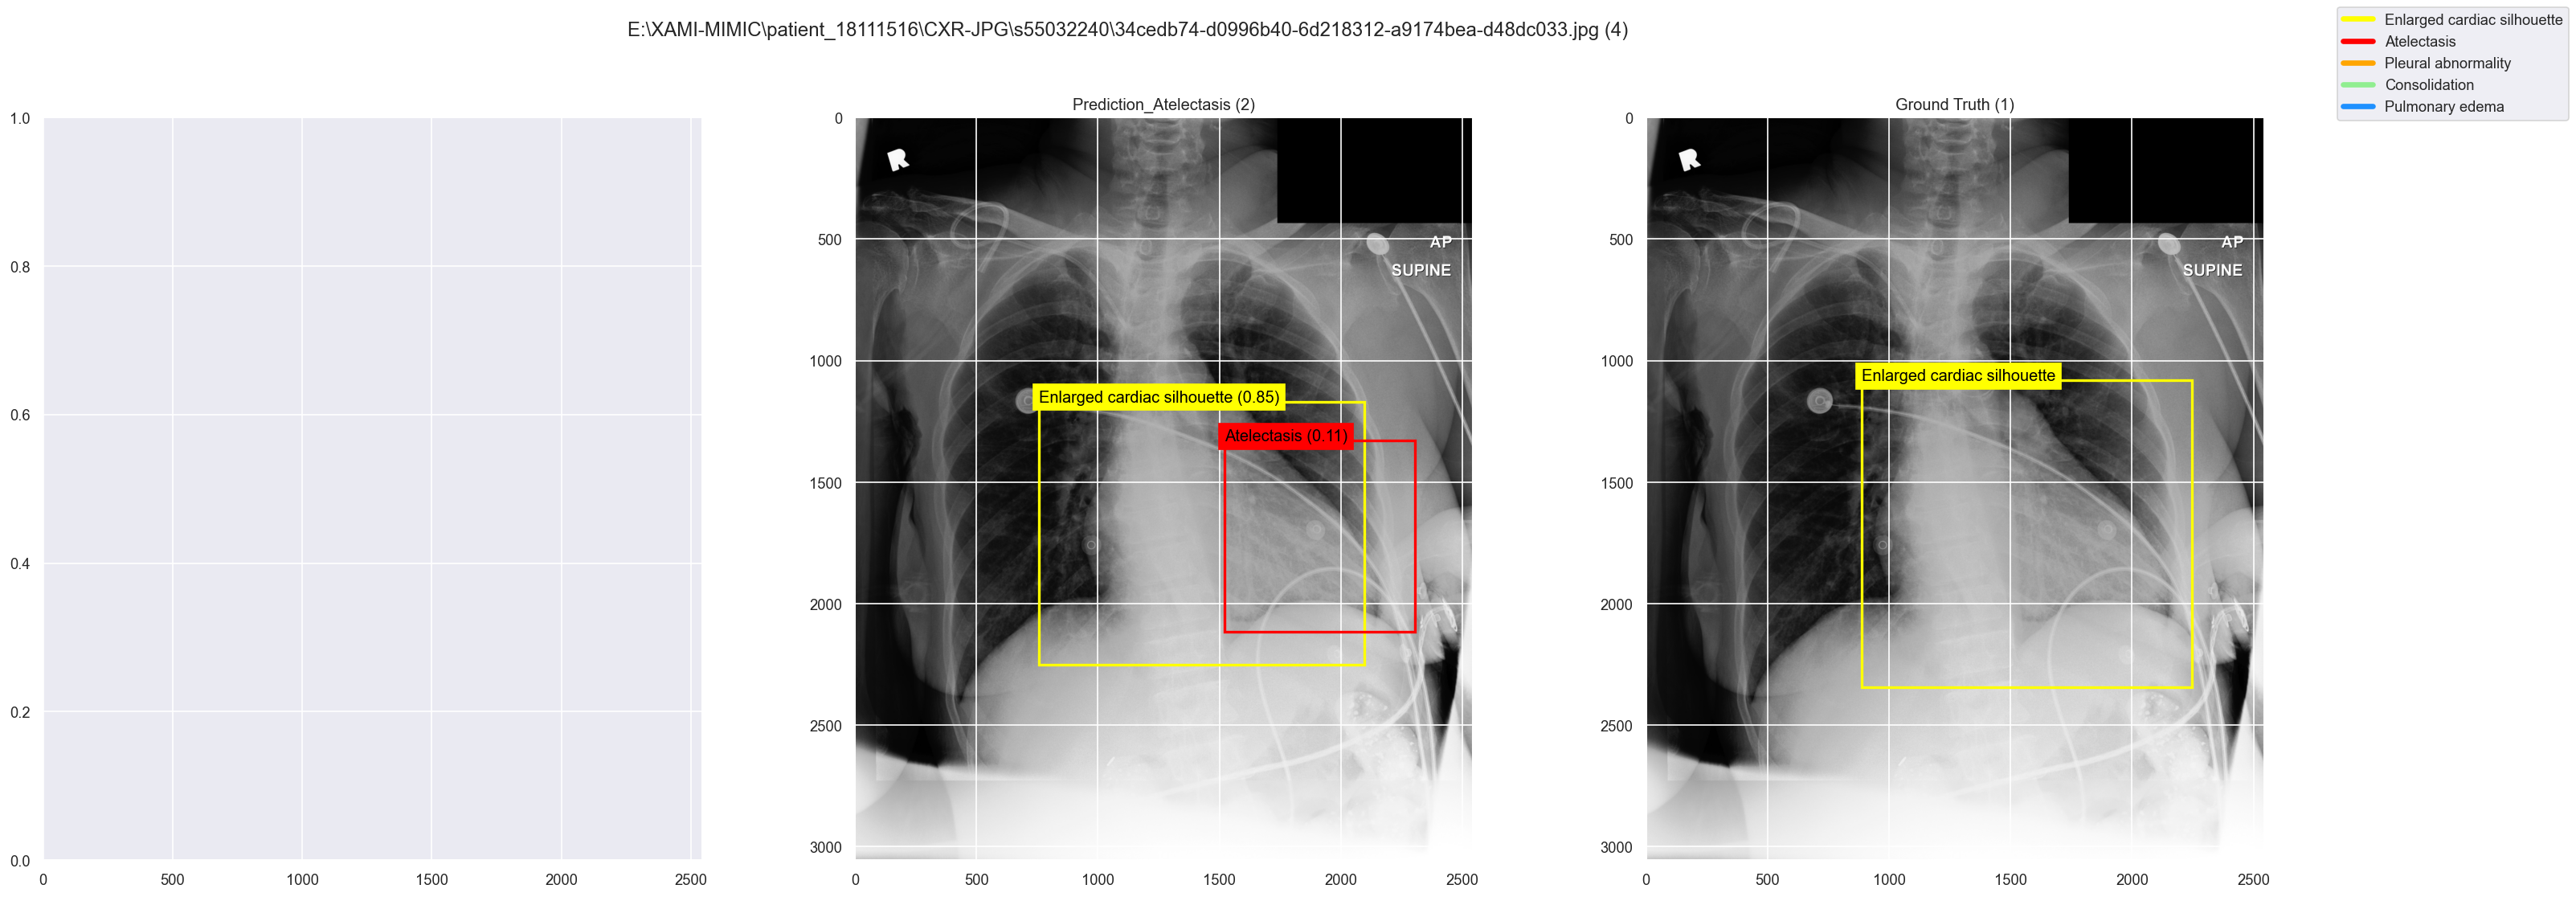

In [48]:
# for generating the example in the paper.

iou_thrs = 0.1 
fig = plot_model_bb_for_dataset_idx(
        model=model,
        train_info=train_info,
        dataset=detect_eval_dataset,
        device=device,
        idx=4, # 200, 50
        legend_elements=legend_elements,
        disease_cmap=DISEASE_CMAP,
        score_thres=None,
        roi_head_thrs=iou_thrs,
        plot_gt=True,
        plot_clinial_3d=False,
        spread_pred=False
    )

  0%|          | 3/3032 [00:19<5:18:09,  6.30s/it]c:\Users\VIMMI\Desktop\multimodal-abnormalities-detection\data\datasets.py:183: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  boxes_df["label"] = boxes_df[self.labels_cols].idxmax(axis=1)
  0%|          | 5/3032 [00:26<3:51:11,  4.58s/it]c:\Users\VIMMI\Desktop\multimodal-abnormalities-detection\data\datasets.py:183: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  boxes_df["label"] = boxes_df[self.labels_cols].idxmax(axis=1)
  0%|          | 6/3032 [00:29<3:30:35,  4.18s/it]c:\Users\VIMMI\Desktop\multimodal-abnormalities-detection\data\datasets.py:183: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

KeyboardInterrupt: 

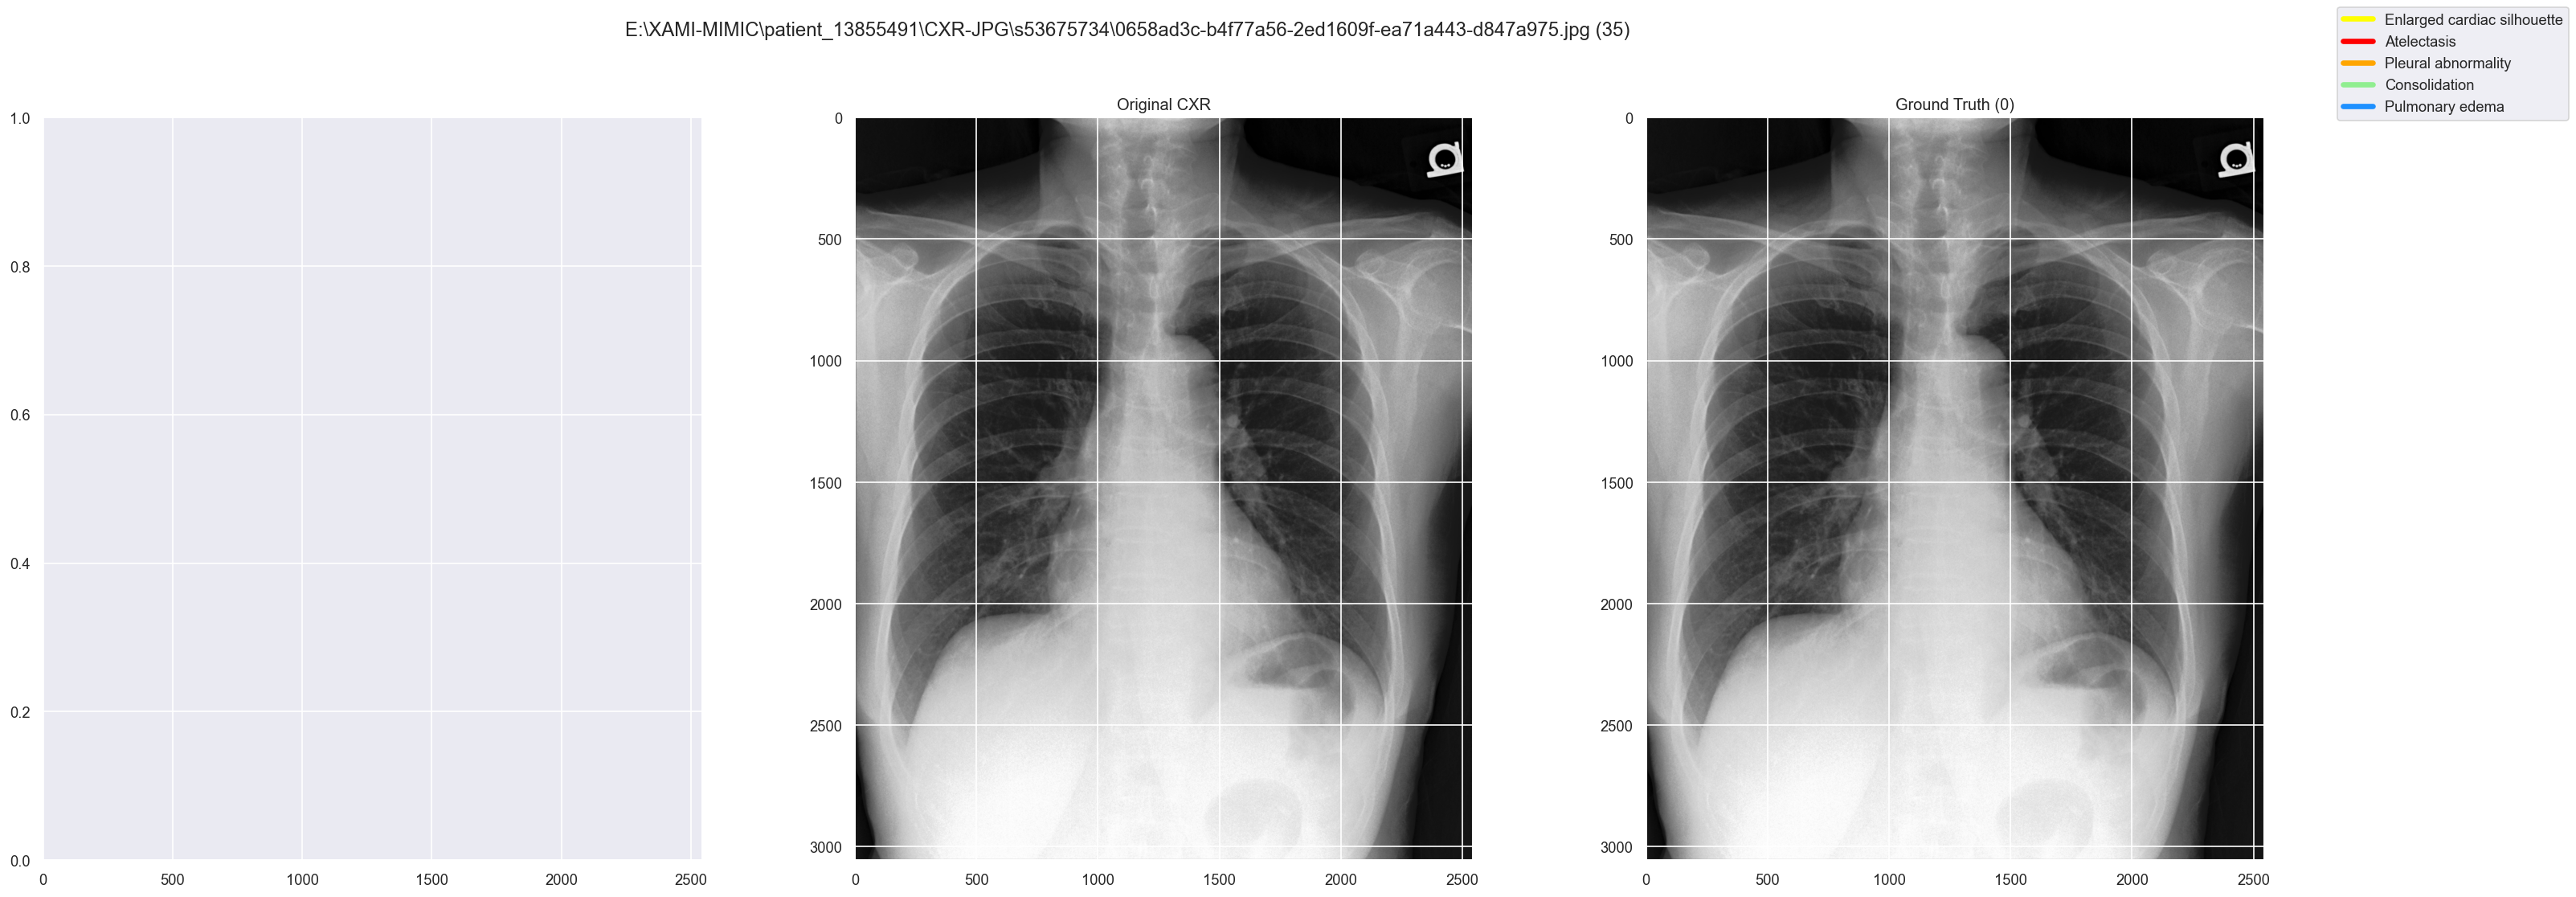

In [23]:
for iou_thrs in [
    # 0.05,
    0.1,
    # 0.3
]:  

    ### modify the naming here.
    destination_folder = os.path.join(
        naming_map[select_model], f"generated_bb (thrs={iou_thrs}) gt & 3-D clinical"
    )
    os.makedirs(naming_map[select_model], exist_ok=True)
    os.makedirs(destination_folder, exist_ok=True)
    os.makedirs(os.path.join(destination_folder, "train"), exist_ok=True)
    os.makedirs(os.path.join(destination_folder, "val"), exist_ok=True)
    os.makedirs(os.path.join(destination_folder, "test"), exist_ok=True)

    for dataset_type in ["train", "val", "test"]:
        df = detect_eval_dataset.df
        commenting_df = pd.DataFrame(df[df["split"] == dataset_type]["dicom_id"])
        max_box_num = 10
        for i in range(1, max_box_num + 1):
            commenting_df[f"Bounding Box {i}"] = [""] * len(commenting_df)

        commenting_df[
            [f"Bounding Box {i}" for i in range(1, max_box_num + 1)] + ["dicom_id"]
        ].to_csv(
            os.path.join(
                destination_folder, dataset_type, f"{dataset_type}_commenting.csv"
            ),
            index_label="ID",
        )

    for idx in trange(0, len(detect_eval_dataset)):
        fig = plot_model_bb_for_dataset_idx(
            model=model,
            train_info=train_info,
            dataset=detect_eval_dataset,
            device=device,
            idx=idx,
            legend_elements=legend_elements,
            disease_cmap=DISEASE_CMAP,
            score_thres=None,
            roi_head_thrs=iou_thrs,
            plot_gt=True,
            plot_clinial_3d=True,
        )
        instance = detect_eval_dataset.df.iloc[idx]
        fig.savefig(
            os.path.join(
                destination_folder,
                instance["split"],
                f"({idx}) {instance['dicom_id']}.png",
            )
        )
        plt.cla()
        plt.clf()
        plt.close("all")


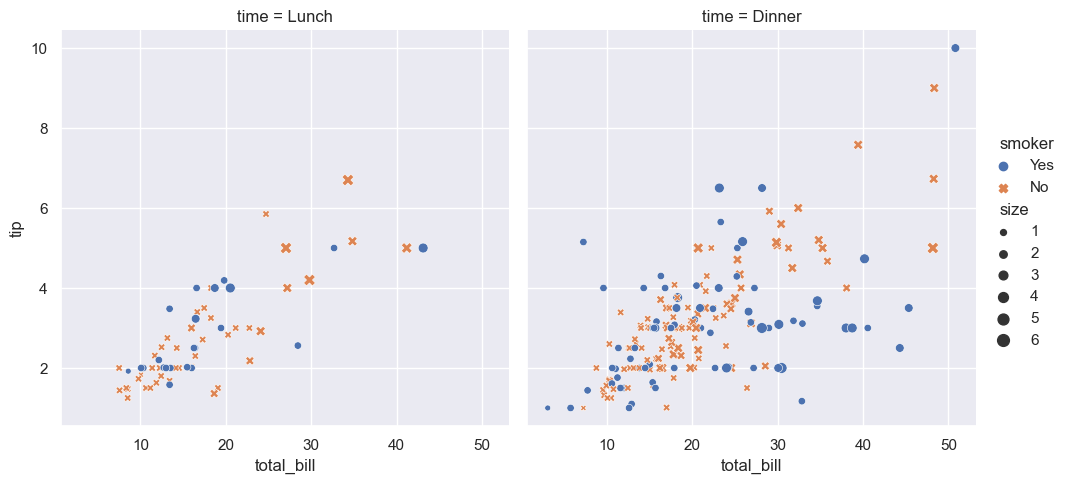

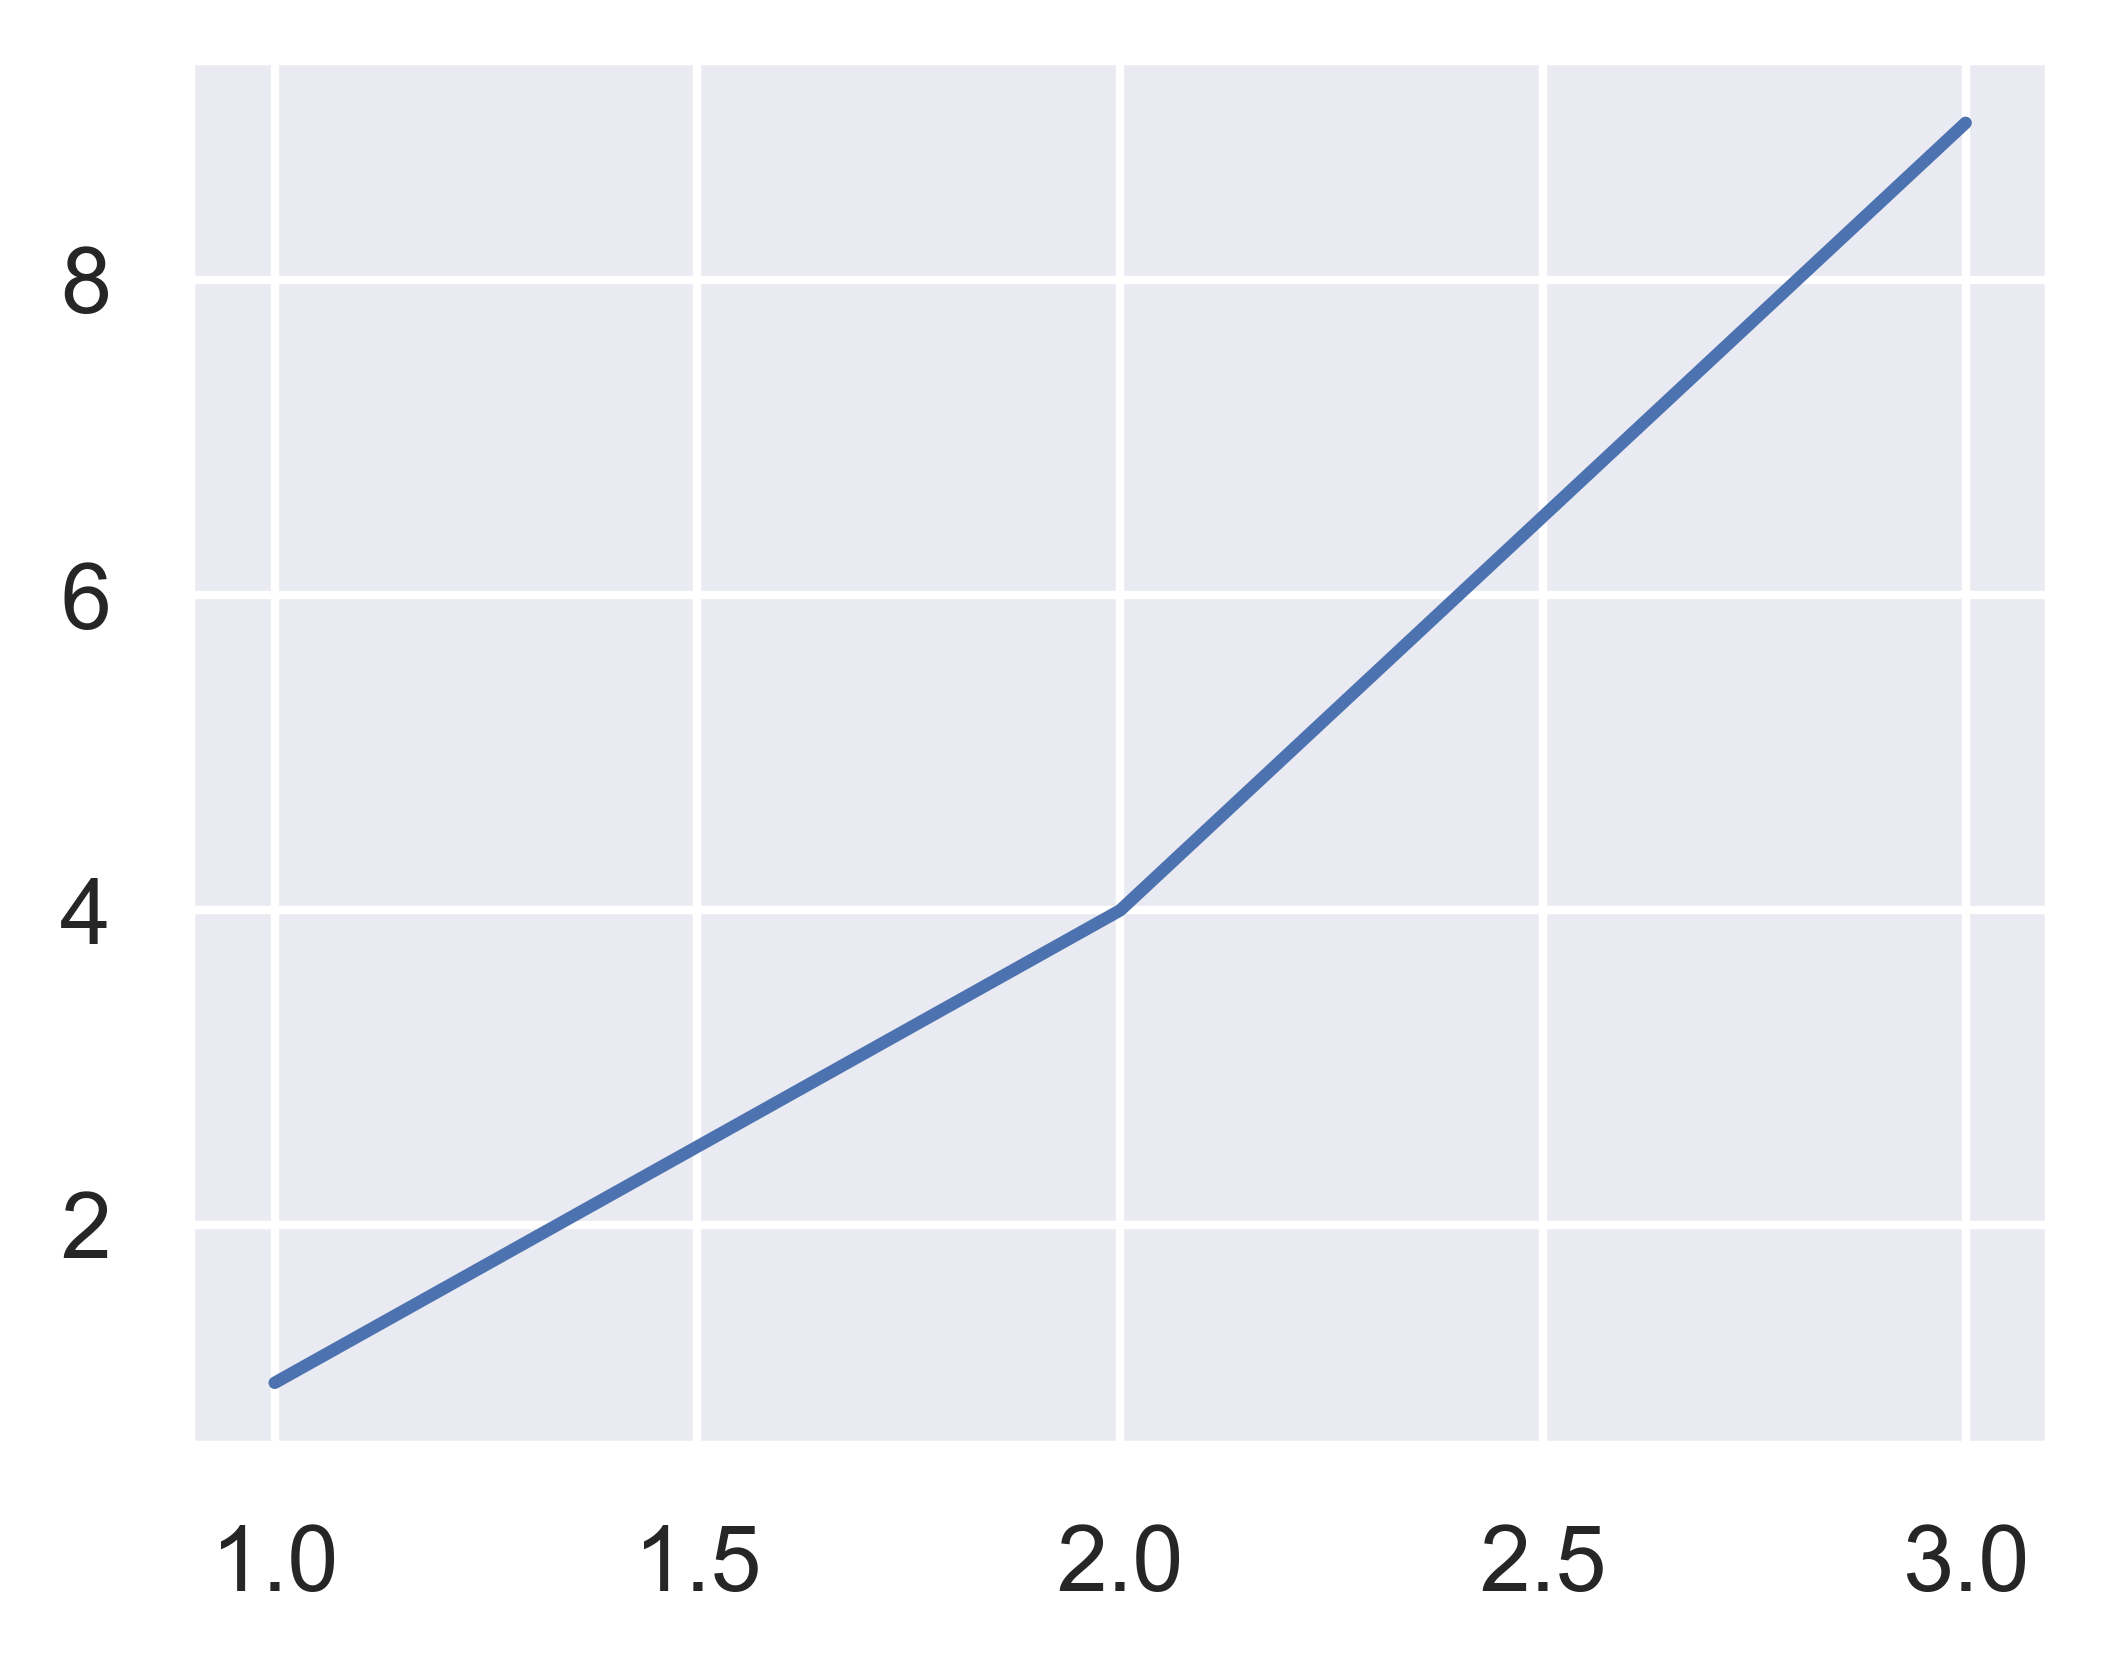

In [1]:
# Import seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme()

# Load an example dataset
tips = sns.load_dataset("tips")

# Create a visualization
sns.relplot(
    data=tips,
    x="total_bill", y="tip", col="time",
    hue="smoker", style="smoker", size="size",
)
# test
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 3), dpi=600)
plt.plot([1, 2, 3], [1, 4, 9])
plt.show()